Арцишевский Антон, 183

In [12]:
import requests
import json
from tqdm.auto import tqdm
import vk
from datetime import datetime
from time import sleep
import nltk
import random
from wordcloud import WordCloud
from tqdm.auto import tqdm
from random import randint

In [6]:
token = '13d415902acc6eea2ab951337fb4c078d720c1b5efef13f799671c15227e0d3ff1a500fef4644e5699e11'
version = '5.92'

In [7]:
session = vk.Session(access_token=token)
vk_api = vk.API(session)

Качаем 1000 комментов

In [14]:
offsets = [0, 100, 2000, 300, 400, 500, 600, 700, 800, 900]
comments = []
for off in offsets:
    comments_100 = requests.get(
                                'https://api.vk.com/method/wall.get',
                                   params={
                                       'domain': 'prostudium', 
                                       'v': version,
                                       'access_token': token,
                                       'count': 100,
                                       'filter': 'others',
                                       'offset': off
                                       }
                               ).json()
    comments.append(comments_100['response']['items'])
                                
    sleep(randint(0, 1))

Функция под доставанию пола и города юзера

In [15]:
    def get_user_info(user_id):
        #sleep(random.random())
        sleep(random.uniform(0.2, 0.4))
        data = requests.get(
            'https://api.vk.com/method/users.get',
            params={
                'user_ids': user_id,
                'fields': 'sex, city',
                'access_token': token,
                'v': version
            }
        ).json()


        u = data.get('response')[0]
        if 'sex' in u:
            if u['sex'] == 1:
                u['sex'] = 'female'
            if u['sex'] == 2:
                u['sex'] = 'male'
            if u['sex'] == 0:
                u['sex'] = 'no gender'
            sex = u['sex']
        else:
            sex = 'None'
        if 'city' in u:
            city = u['city']['title']
        else:
            city = 'None'
        

        return sex, city

In [16]:
from pymorphy2 import MorphAnalyzer
import time
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
morph = MorphAnalyzer()

Лемматизация текста поста на пайморфи. Отчищена от стоп слов, знаков препинания и приведена к нижнему регистру.

In [17]:
def lemmatize(text):
    words = [w.lower() for w in word_tokenize(text) if w.isalpha()]
    # text = [word for word in text if word != '']

    lemmas = []

    for word in text:
        lemmas.append(morph.parse(word)[0].normal_form)

    sw = stopwords.words('russian')
    sw.append('всем, привет, вопрос, спасибо, здравствуйте, пожалуйста, просто, добрый, подскажите, пока, ещё, буду, могу, это, очень, нужно')
    words = [w.lower() for w in word_tokenize(text) if w.isalpha()]
    
    cleared_words = []
    for word in words:
        if word in sw:
            continue
        else:
            cleared_words.append(word)
        
    return cleared_words

Сосбсна основная махина. Распаковывает комменты, достает оттудова айди юзера, текст (потом лемматизирует его), лайки, время поста, пол и город юзера.
В конце добавляет получившийся словарик в списочек.

In [18]:
data1 = []


for comments_100 in tqdm(comments):
    for comment in tqdm(comments_100):
        d = {'user_id': int, 'text': str, 'lemmas': str, 'likes': int, "hour": int, 'sex': str, 'city': str, 'len_text': int}
        user_id = comment['from_id'] # user id
    
        text = comment['text'] # text
    
        lemmas = lemmatize(text)
    
        likes = comment['likes']['count']
    
        hour = comment['date'] # text
        hour = datetime.fromtimestamp(hour) # converting unixtime into utc
        hour = hour.hour
    
        d['user_id'] = user_id
        d['text'] = text
        d['lemmas'] = lemmas
        d['likes'] = likes
        d['hour'] = hour
        d['len_text'] = len(text)
    
        user_info = get_user_info(user_id)
        user_info = list(user_info)
        d['sex'] = user_info[0]
        d['city'] = user_info[1]
        data1.append(d)

Рисуем. Сначала оформлю дф и запихну его в файл с разделением по табуляции (так красивше)

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import pandas as pd
random.seed = 23

In [20]:
df = pd.DataFrame(data1)

In [21]:
df

,user_id,text,lemmas,likes,hour,sex,city,len_text
0,156262017,Всем привет! Надеюсь кто-то сможет проконсульт...,"[всем, привет, надеюсь, сможет, проконсультиро...",2,21,female,München,389
1,167827070,Всем привет! \nВопрос к студентам медикам.\nЧт...,"[всем, привет, вопрос, студентам, медикам, так...",3,21,male,Сызрань,258
2,351349690,Добрый вечер! Те кто учился/учиться в штк Лейп...,"[добрый, вечер, те, штк, лейпциг, расскажите, ...",5,18,male,Гомель,257
3,170352709,Привет! Получил по почте присяжный перевод от ...,"[привет, получил, почте, присяжный, перевод, п...",4,18,male,Алматы,271
4,561775493,AБХ Бонна \nЗначит-ли это что АБХ всех или бол...,"[aбх, бонна, это, абх, большинства, земель, бу...",5,15,female,Москва,102
...,...,...,...,...,...,...,...,...
995,189509916,Несколькими постами ниже вопрос про прилёт в Г...,"[несколькими, постами, ниже, вопрос, прилёт, г...",8,16,female,None,375
996,13336576,"А кто-нибудь знает, это правда, что студентам ...","[знает, это, правда, студентам, работать, часо...",7,14,female,Москва,255
997,327993335,"Добрый день, у меня такой вопрос \nПосле 9 кла...","[добрый, день, вопрос, класса, семьей, перееха...",8,14,female,None,669
998,31728406,"Ребят, вопрос совсем не по теме сообщества, но...","[ребят, вопрос, теме, сообщества, думаю, смогу...",12,13,female,None,199


In [22]:
df.to_csv('some_file.csv', sep='\t', index=False)

Пора строить зависимости. Выбирал графики исходя из своих метапараметров (могло быть конечно и лучше)<br>
## График зависимости лайков от пола. Что он говорит? <br>
1) Мужчины получаеют меньше лайков <br>
2) Основное кол-во лайков колеблеться от 0 до 20 (50+ лайков скорее всего посты админа или конкурсы)<br>

Text(0, 0.5, 'sex')

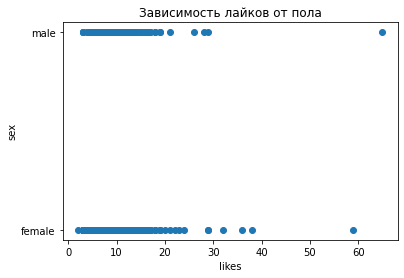

In [23]:
df_sl = df[(df['sex'] != 0)][['likes', 'sex']]

fig, ax = plt.subplots()

ax.scatter(df_sl['likes'], df_sl['sex'])
ax.set_title('Зависимость лайков от пола')
ax.set_xlabel('likes')
ax.set_ylabel('sex')

## Зависимость кол-ва лайков от часа публикации. Показывает активность сообщества.

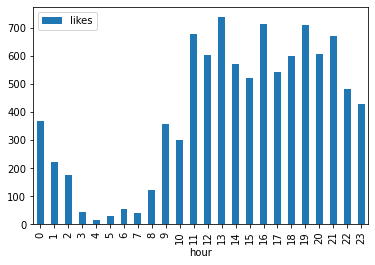

In [24]:
df4 = df[['hour', 'likes']]
dff = df4.groupby('hour')
dff.sum().plot.bar()

In [40]:
df4 = df[['hour', 'likes']]
dff = df4.groupby('hour')
dff.sum()

,likes
hour,
0,369
1,222
2,176
3,43
4,14
5,28
6,54
7,40
8,122


## График зависимости пола и часа публикации (может конечно лучше было бы сделать в процентах, но мне так тоже нравиться).
О чём он нам говорит?<br>
*1) Мужчины пишут меньше постов <br>
2) Высокая активность продолжается с 11 до 23 часов (что много) <br>
3) Активность просидает у м и ж в 15 и 17 часов (можно поискать причины) <br>
4) В целом мужчины и женщины проявляют общую тенденцию (за исключением 12 и 15 часов)*

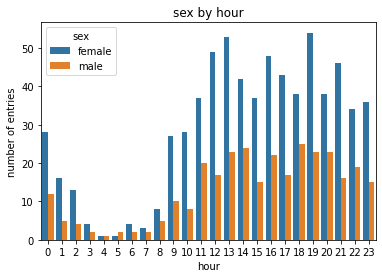

In [25]:
df_sh = df[
    (df['sex'] != 'no gender')
][
    ['hour', 'sex', 'user_id']
].groupby(['hour', 'sex'], as_index=False).count()
df_sh.columns = ['hour', 'sex', 'total']
sns.barplot(x="hour", y="total", hue='sex', data=df_sh)
plt.title('sex by hour')
plt.xlabel('hour')
plt.ylabel('number of entries');

## Wordclouds

In [26]:
import operator
manly_lemmas = []
for user in data1:
    if user['sex'] == 'male':
        for lemma in user['lemmas']:
            manly_lemmas.append(lemma)

ml = {}            
for lemma in manly_lemmas:
    if lemma not in ml:
        ml.update({lemma: 1})
    else:
        #ml.update({lemma: +=1})
        ml[lemma] += 1
        #ml.update
sorted_ml = sorted(ml.items(), key=operator.itemgetter(1), reverse=True)
#sorted_ml[0:29]

In [27]:
df_ml = pd.DataFrame(sorted_ml)
x = df_ml.head(30)

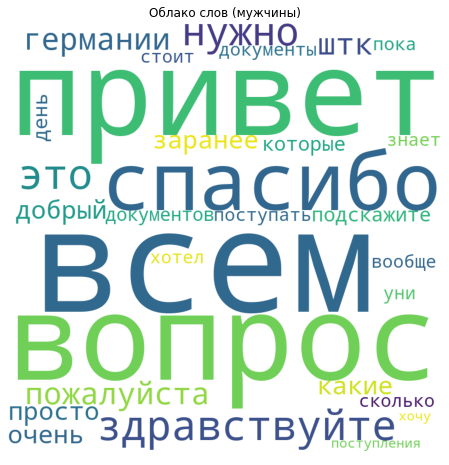

In [28]:
wordcloud = WordCloud(
    background_color ='white',
    width = 800,
    height = 800, 
).generate(' '.join(x[0]))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.title('Облако слов (мужчины)')
plt.show()

In [29]:
sw

NameError: name 'sw' is not defined

In [ ]:
women_lemmas = []
for user in data1:
    if user['sex'] == 'female':
        for lemma in user['lemmas']:
            women_lemmas.append(lemma)            

wl = {}         
for lemma in women_lemmas:
    if lemma not in wl:
        wl.update({lemma: 1})
    else:
        #ml.update({lemma: +=1})
        wl[lemma] += 1
        #ml.update
        
sorted_wl = sorted(wl.items(), key=operator.itemgetter(1), reverse=True)

In [ ]:
df_wl = pd.DataFrame(sorted_wl)
y = df_wl.head(30)

In [ ]:
wordcloud = WordCloud(
    background_color ='white',
    width = 800,
    height = 800, 
).generate(' '.join(y[0]))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off") 
plt.title('Облако слов (женщины)')
plt.show()

## Попытка создать временную активность в зависимости от города (пытаюсь пофиксить, но это как доп график).
## <br>График зависимости часа от города

In [ ]:
    x_label="hour"
    y_label="city"
    title="hour by city"
    color = "r"
    yscale_log=False
    _, ax = plt.subplots()

    # Plot the data, set the size (s), color and transparency (alpha)
    # of the points
    x_data = df['hour']
    y_data = df['city']
    ax.scatter(x_data, y_data, s = 10, color = color, alpha = 0.75)

    if yscale_log == True:
        ax.set_yscale('log')

    # Label the axes and provide a title
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

In [ ]:
df_sh = df[
    ['hour', 'city', 'user_id']
].groupby(['hour', 'city'], as_index=False).count()
df_sh.columns = ['hour', 'city', 'total']
sns.barplot(x="hour", y="total", hue='city', data=df_sh)
plt.title('city by hour')
plt.xlabel('hour')
plt.ylabel('number of entries');

In [ ]:
df_ch = df[
    (df['sex'] != 0)
][
    ['city', 'sex', 'user_id']
].groupby(['city', 'sex'], as_index=False).count()
df_ch.columns = ['city', 'sex', 'total']
sns.barplot(x="city", y="total", hue='sex', data=df_ch)
plt.title('city by hour')
plt.xlabel('hour')
plt.ylabel('number of entries');

Смотрим top-30 лемм у мужчин

Смотрим top-30 лемм у женщин

О чём говорят эти облака? Что люди вежливые :D И кому-то что-то нужно

# ЕЩЁ ГРАФИК ЕСЛИ В ПРОШЛЫХ ЧТО-ТО НЕ ТАК <BR>
    
## Теперь график зависимости длины текста и кол-ва лайков

Показывает, что чем длинее посты, тем больше лайков

In [ ]:
df5 = df[['len_text', 'likes']]
df6 = df5.groupby('likes')
df6.sum().plot.bar()

Попытка создать город/час

In [ ]:
res = df.sort_index().sort_values('city', kind='mergesort')

In [ ]:
cities = {}
for city in res['city']:
    if city in cities:
        n = cities[city]
        cities[city] += 1
    else:
        cities.update({city: 1})

cities = sorted(cities.items(), key=lambda x: x[1], reverse=True)
#cities